<a href="https://colab.research.google.com/github/cullena20/RedditSentiment/blob/main/RedditSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Sentiment Analysis!

In [1]:
from IPython import display  # control displaying of printed output in loops
import math
from pprint import pprint  # pretty print json and lists
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
!pip install praw
import praw

     |████████████████████████████████| 153kB 6.1MB/s 
     |████████████████████████████████| 204kB 20.5MB/s 


In [17]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Exploring the Reddit API using PRAW

Access the Reddit API. To do this go to https://www.reddit.com/prefs/apps/

In [2]:
reddit = praw.Reddit(client_id='etCTL0OgGAY1jA',
                     client_secret='vMtYIGE5WVK8BDczKh7ZnRup3rb3ew',
                     user_agent='Conscious-Reply-7037',
                     username='Conscious-Reply-7037')

In [13]:
# subreddit1 = reddit.subreddits.search_by_name('datascience', exact=True)  returns a list of search results
subreddit = reddit.subreddit('datascience')
print("Display Name:")
print(subreddit.display_name) 
print()
print("Title:")
print(subreddit.title)   
print()
print("Description")      
print(subreddit.description) 

Subreddit(display_name='datascience')

In [37]:
posts = set()  # use a set to clear any duplicates
for submission in politics.new(limit=None):
  posts.add(submission)
  display.clear_output()  # only one output that changes
  print(len(posts))
posts = list(posts)  # easier to work with lists

905


In [42]:
post = posts[2]
print(post.title)
print(post.author)
print(post.score)
print(post.id)
print(post.url)

GOP Sen. Josh Hawley was isolated 'in a corner' of a secure room 'with no one talking to him or acknowledging him' during Capitol siege: WSJ
stem12345679
1189
kttf9n
https://www.businessinsider.com/josh-hawley-isolated-capitol-siege-riots-electoral-college-republican-blowback-2021-1


## Some Text Preprocessing


Preprocess the data by tokenizing it.

We will first use word_tokenize from nltk.

In [145]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')  # needed for word_tokenize
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Another method to split up article into sentences and them average the positive and negative scores.

In [158]:
from nltk.tokenize import sent_tokenize, word_tokenize
article = "Google staff awoke on Wednesday to surprising news: Their company is working on a search app tailored, and censored, for China. The project, kept secret from all but select teams and leaders, sparked a furious internal debate. Yet the move couldn’t have been entirely surprising for Googlers."
article_tokenized = sent_tokenize(article)

print(article_tokenized)
neg_scores = []
pos_scores = []
for i in article_tokenized:
    print(sia.polarity_scores(i))
    neg_scores.append(sia.polarity_scores(i)['neg'])
    pos_scores.append(sia.polarity_scores(i)['pos'])

['Google staff awoke on Wednesday to surprising news: Their company is working on a search app tailored, and censored, for China.', 'The project, kept secret from all but select teams and leaders, sparked a furious internal debate.', 'Yet the move couldn’t have been entirely surprising for Googlers.']
{'neg': 0.074, 'neu': 0.829, 'pos': 0.097, 'compound': 0.128}
{'neg': 0.265, 'neu': 0.735, 'pos': 0.0, 'compound': -0.7227}
{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.3384}


I found this code on Github. Let's try it out.
Update: word_tokenize works better

In [ ]:
# !pip install git+https://github.com/erikavaris/tokenizer.git
# from tokenizer import tokenizer
# R = tokenizer.RedditTokenizer()

In [153]:
sentence = "yo whats up /u/MrJones?! Check out r/spacedicks!"
print(word_tokenize(sentence))
# print(R.tokenize(sentence))

['yo', 'whats', 'up', '/u/MrJones', '?', '!', 'Check', 'out', 'r/spacedicks', '!']


In [118]:
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# !python -m spacy download en_core_web_md
# import en_core_web_md
# nlp = en_core_web_md.load()

# def tokenize_vecs(text):
#     clean_tokens = []
#     for token in nlp(text):
#         if (not token.is_stop) and (token.lemma_ != '-PRON-') and (not token.is_punct): 
#           # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
#             clean_tokens.append(token)
#     return clean_tokens

# def word2vec(x):
#   word2vec = []
#   for text in x:
#     review = tokenize_vecs(text)
#     review_average = 0
#     for word in review:
#       word = word.vector
#       review_average += word
#     review_average /= len(review)
#     word2vec.append(review_average)

#   return np.array(word2vec)
#   sentence = "This food was great but the service was only okay"

# tokenize_vecs(sentence)

## Basic Sentiment Analysis Using Pretrained Models


For now, we will explore various pretrained models that detect negative and positive sentiment. Alternativley, we could train our own model using a dataset and sklearn. However, this will do for now.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
from textblob import TextBlob
!pip install flair
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [138]:
sentence = "This food was great but the service was only okay"
print("NLTK VADER")
print(sia.polarity_scores(sentence))
print()
print("Text Blob:")
print(TextBlob(sentence).sentiment)
print()
print("Flair:")
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
print(total_sentiment)

NLTK VADER
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5994}

Text Blob:
Sentiment(polarity=0.43333333333333335, subjectivity=0.75)

Flair:
[POSITIVE (0.5546)]


So none of these models are making use of the word vectors I believe. So scrap this and worry about removing stop words and stuff instead.

In [139]:
# token_sentence = tokenize_vecs(sentence)
# token_sentence = str(token_sentence)
# print("NLTK VADER")
# print(sia.polarity_scores(token_sentence))
# print()
# print("Text Blob:")
# print(TextBlob(token_sentence).sentiment)
# print()
# print("Flair:")
# s = flair.data.Sentence(token_sentence)
# flair_sentiment.predict(s)
# total_sentiment = s.labels
# print(total_sentiment)

NLTK VADER
{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

Text Blob:
Sentiment(polarity=0.65, subjectivity=0.625)

Flair:
[POSITIVE (0.8358)]


In [52]:
results = list()

for post in posts:
    pol_score = sia.polarity_scores(post.title)
    pol_score['headline'] = post.title
    results.append(pol_score)

pprint(results[:3], width=100)  # pretty print

[{'compound': -0.7184,
  'headline': 'Google Play suspends Parler for failure to moderate posts that incite violence - '
              'CBS News',
  'neg': 0.356,
  'neu': 0.529,
  'pos': 0.115},
 {'compound': -0.2263,
  'headline': 'Noem issues order to direct lawsuit against recreational pot',
  'neg': 0.192,
  'neu': 0.808,
  'pos': 0.0},
 {'compound': -0.2732,
  'headline': "GOP Sen. Josh Hawley was isolated 'in a corner' of a secure room 'with no one "
              "talking to him or acknowledging him' during Capitol siege: WSJ",
  'neg': 0.161,
  'neu': 0.753,
  'pos': 0.086}]


In [62]:
df = pd.DataFrame.from_records(results)
df['label'] = 0  # creates label column
df.loc[df['compound'] > 0.2, 'label'] = 1  # if compound score is greater than 0.2 we label it as positive
df.loc[df['compound'] < -0.2, 'label'] = -1  # if compound score is less than -0.2 we label it as positive
df.sample(n=10,axis='rows')  # prints 10 random items from the dataframe

,neg,neu,pos,compound,headline,label
320,0.000,1.000,0.000,0.0000,"Iowa GOP, Senate Democrats pick their nominees...",0
136,0.266,0.734,0.000,-0.4404,Biden assembling multitrillion-dollar stimulus...,-1
195,0.127,0.613,0.260,0.6597,Republican Attorneys General Association Encou...,1
649,0.250,0.671,0.079,-0.5859,Majority of Americans want Trump removed immed...,-1
418,0.310,0.690,0.000,-0.5574,Capitol riot was openly organized on mainstrea...,-1
89,0.000,1.000,0.000,0.0000,Kim Jong-un calls US ‘biggest enemy’ and says ...,0
732,0.255,0.745,0.000,-0.3400,An Air Force Combat Veteran Breached the Senate,-1
334,0.190,0.564,0.246,0.0258,It Doesn’t Look Like Trump Can Pardon Himself ...,0
569,0.181,0.714,0.105,-0.3818,Biden likens Ted Cruz to Nazi propagandist Goe...,-1
9,0.268,0.732,0.000,-0.5106,Capitol riots renew calls for D.C. to become 5...,-1


Now that we have our results, we can save them in a csv file!

In [65]:
result_df = df[['headline', 'label']]
result_df.to_csv('reddit_headline_sentiment.csv', mode='a', encoding='UTF-8', index=False)

## Exploring Our Results

In [76]:
positive_results = df[df['label'] == 1]
negative_results = df[df['label'] == -1]
print("Postitive Results:")
pprint(list(positive_results['headline'])[:5]) 
print()
print("Negative Results:")
pprint(list(negative_results['headline'])[:5]) 

Postitive Results:
['‘Inside job’: House Dems ask if Capitol rioters had hidden help',
 "Lehigh University has rescinded Trump's honorary degree",
 "Biden says Trump skipping inauguration is 'a good thing'",
 'It’s a Little Late for Mike Pence to Pose as a Brave Dissenter to Donald '
 'Trump',
 'Trump Administration Politicized Some Intelligence on Foreign Election '
 'Influence, Report Finds']

Negative Results:
['Google Play suspends Parler for failure to moderate posts that incite '
 'violence - CBS News',
 'Noem issues order to direct lawsuit against recreational pot',
 "GOP Sen. Josh Hawley was isolated 'in a corner' of a secure room 'with no "
 "one talking to him or acknowledging him' during Capitol siege: WSJ",
 "Flashback: Trump accuses Cruz of stealing Iowa caucuses through 'fraud'",
 'As riot raged at Capitol, Trump tried to call senators to overturn election']


In [83]:
percentages = df.label.value_counts(normalize=True) * 100
print("Count:")
print(df.label.value_counts())
print()
print("Percentages:")
print(percentages)

Count:
-1    424
 0    335
 1    146
Name: label, dtype: int64

Percentages:
-1    46.850829
 0    37.016575
 1    16.132597
Name: label, dtype: float64


[]

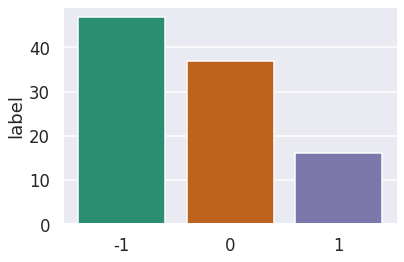

In [88]:
sns.barplot(x=percentages.index, y=percentages)
plt.xlabel = ['Negative', 'Nuetral', 'Positive']
plt.plot()

## More with the Reddit API

Let's take this a bit further and explore comments in posts!

In [179]:
# this creates a list of comments from the post we already defined
comments = list(post.comments)
# pprint(vars(comments[1]))  # gives us variables for comment
print(post.title)
print(comments[1].author)
print(comments[1].body)
print(comments[1].score)  # would be nice to have model weigh this too

Lawmakers renew calls for DC statehood after Capitol riot
TheArtfulDodger518
Call and write your reps. Statehood for Puerto Rico and DC should be top priority.
28


In [184]:
! python -- version

Python 3.6.9
